In [1]:
import tensorflow as tf
import numpy as np
import pandas as pd
import matplotlib as plt
from sklearn.metrics import confusion_matrix
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from tensorflow.keras.optimizers import Adam

### 1. Data Prep

In [2]:
# Importing & reading csv to prep for input

data = pd.read_csv('fer2013.csv')
data

,emotion,pixels,Usage
0,0,70 80 82 72 58 58 60 63 54 58 60 48 89 115 121...,Training
1,0,151 150 147 155 148 133 111 140 170 174 182 15...,Training
2,2,231 212 156 164 174 138 161 173 182 200 106 38...,Training
3,4,24 32 36 30 32 23 19 20 30 41 21 22 32 34 21 1...,Training
4,6,4 0 0 0 0 0 0 0 0 0 0 0 3 15 23 28 48 50 58 84...,Training
...,...,...,...
35882,6,50 36 17 22 23 29 33 39 34 37 37 37 39 43 48 5...,PrivateTest
35883,3,178 174 172 173 181 188 191 194 196 199 200 20...,PrivateTest
35884,0,17 17 16 23 28 22 19 17 25 26 20 24 31 19 27 9...,PrivateTest
35885,3,30 28 28 29 31 30 42 68 79 81 77 67 67 71 63 6...,PrivateTest


In [3]:
# labeling
emotion_labels = {0:'Angry', 1:'Digust', 2:'Fear', 3:'Happy', 4:'Sad', 5:'Surprise', 6:'Neutral'}
emotion_counts = data['emotion'].value_counts(sort=True).reset_index()
emotion_counts.columns = ['emotion', 'number']
emotion_counts['emotion'] = emotion_counts['emotion'].map(emotion_labels)
emotion_counts

,emotion,number
0,Happy,8989
1,Neutral,6198
2,Sad,6077
3,Fear,5121
4,Angry,4953
5,Surprise,4002
6,Digust,547


In [33]:
# normalizing
x = []
for pixel_sequence in data["pixels"]:
    pixels = np.array(pixel_sequence.split(" "), dtype='uint8').reshape(48, 48, 1) # 48 x 48 w/ 1 channel (greyscale)
    x.append(pixels)
x = np.array(x) / 255.0  
y = to_categorical(data["emotion"], num_classes = 7)

In [7]:
# splitting into training, validation and test sets
train = data[data['Usage']=='Training'].copy()
val = data[data['Usage']=='PublicTest'].copy()
test = data[data['Usage']=='PrivateTest'].copy()
train_x, test_x, train_y, test_y = train_test_split(x, y, test_size=0.2, random_state=42)
print("train shape: {}, \nvalidation shape: {}, \ntest shape: {}".format(train.shape, val.shape, test.shape))

train shape: (28709, 3), 
validation shape: (3589, 3), 
test shape: (3589, 3)


In [34]:
# Visualizing input images:

def row2image(row): # defining new function to translate pixels to image
    pixels = row['pixels'] 
    emotion = emotion_labels[row['emotion']] # access data from emotion_labels dictionary 
    img = np.array(pixels.split(), dtype=np.uint8) 
    img = img.reshape(48, 48) # create a three-channel image
    image = np.repeat(img[:, :, np.newaxis], 3, axis=2)
    return image, emotion

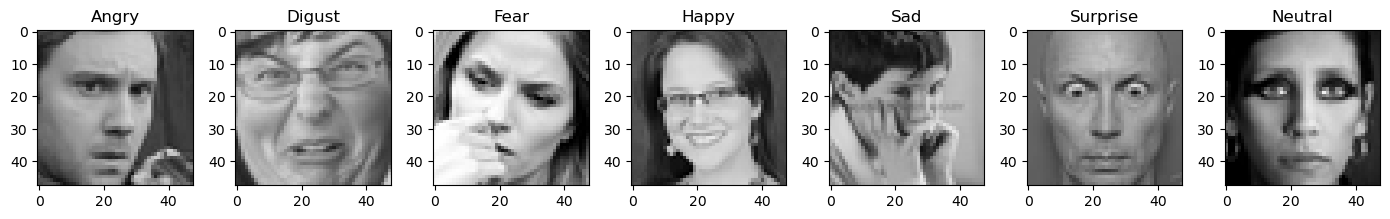

In [35]:
plt.figure(figsize=(14,9))
for i in range(1, 8):
    face = data[data['emotion'] == i-1].iloc[0]
    img, emotion = row2image(face)
    plt.subplot(1, 7, i)
    plt.imshow(img, cmap='gray')  # Plot grayscale image
    plt.title(emotion)
plt.tight_layout()
plt.show()

### 2. Baseline Model

In [41]:
from tensorflow import keras
# Baseline model:

model = tf.keras.models.Sequential([
    tf.keras.layers.Flatten(), # converts 2d image to vector layer
    tf.keras.layers.Dense(120, activation='relu'),
    tf.keras.layers.Dense(84, activation='relu'),
    tf.keras.layers.Dense(7, activation='relu'),
    tf.keras.layers.Dense(7, activation='softmax') # probabilities 
])

# Compiling
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Training
history = model.fit(train_x, train_y, epochs = 20, batch_size = 48, validation_data = (test_x, test_y), verbose=1)

Epoch 1/20
599/599 [==============================] - 1s 2ms/step - loss: 1.8188 - accuracy: 0.2527 - val_loss: 1.7772 - val_accuracy: 0.2662
Epoch 2/20
599/599 [==============================] - 1s 2ms/step - loss: 1.7528 - accuracy: 0.2976 - val_loss: 1.7628 - val_accuracy: 0.2799
Epoch 3/20
599/599 [==============================] - 1s 2ms/step - loss: 1.7116 - accuracy: 0.3227 - val_loss: 1.7102 - val_accuracy: 0.3239
Epoch 4/20
599/599 [==============================] - 1s 2ms/step - loss: 1.6867 - accuracy: 0.3391 - val_loss: 1.7683 - val_accuracy: 0.2758
Epoch 5/20
599/599 [==============================] - 1s 2ms/step - loss: 1.6743 - accuracy: 0.3424 - val_loss: 1.6979 - val_accuracy: 0.3335
Epoch 6/20
599/599 [==============================] - 1s 2ms/step - loss: 1.6620 - accuracy: 0.3502 - val_loss: 1.6748 - val_accuracy: 0.3426
Epoch 7/20
599/599 [==============================] - 1s 2ms/step - loss: 1.6428 - accuracy: 0.3604 - val_loss: 1.6455 - val_accuracy: 0.3605
Epoch 

In [42]:
# Testing Accuracy 

from sklearn.metrics import accuracy_score

# Convert one-hot encoded test labels back to categorical labels
test_true = np.argmax(test_y,axis=1)
# Predict the labels for the test data
test_pred = np.argmax(model.predict(test_x), axis = 1)
# Compute the accuracy score for the test data
# Print the test accuracy
print("Test Accuracy {:.2f}".format(accuracy_score(test_true, test_pred)*100))

# Evaluate the train performance

# Convert one-hot encoded train labels back to categorical labels
train_true = np.argmax(train_y,axis=1)
# Predict the labels for the train data
train_pred = np.argmax(model.predict(train_x), axis = 1)
# Compute the accuracy score for the train data
# Print the train accuracy
print("Train Accuracy {:.2f}".format(accuracy_score(train_true, train_pred)*100))

225/225 [==============================] - 0s 632us/step
Test Accuracy 36.53
898/898 [==============================] - 1s 617us/step
Train Accuracy 38.67


<Axes: >

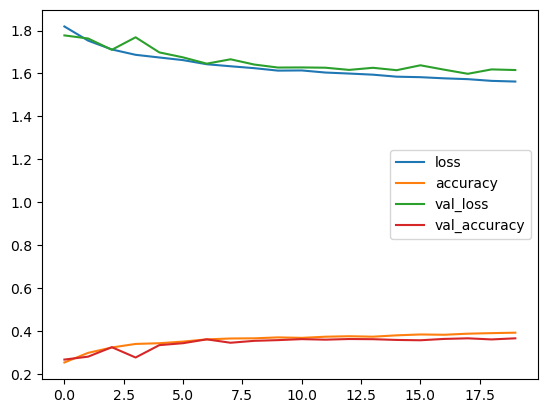

In [43]:
pd.DataFrame(history.history).plot()
 
# model may be too simple to extract any patterns from data

### Model 1

increased model complexity 
- added more layers (convolutional, maxpooling, & dropout)

In [44]:
# Model 1

from tensorflow.keras.models import Sequential
from tensorflow.keras import layers
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import Dropout

model = Sequential()

# First convolutional  layer
# 6 filters, each with a 5x5 kernel, ReLU activation function
# Input shape: (48, 48, 1) - input images of size 48x48 pixels with 1 channel (grayscale)
model.add(layers.Conv2D(6, (5, 5), activation='relu', input_shape=(48, 48, 1)))

# First max-pooling layer
# Max pooling with a 2x2 window size, reducing spatial dimensions by half
model.add(layers.MaxPooling2D((2, 2)))

# Second convolutional layer  
# 16 filters, each with a 5x5 kernel, ReLU activation function
model.add(layers.Conv2D(16, (5, 5), activation='relu'))

# Second max-pooling layer
# Max pooling with a 2x2 window size, reducing spatial dimensions by half
model.add(layers.MaxPooling2D((2, 2)))

# Flatten layer to convert 2D feature maps to 1D feature vectors
model.add(layers.Flatten())

# DROPOUT 1 (temp regularization)
# First fully connected layer
# 120 vectors with activation function ReLu 
model.add(layers.Dense(120, activation='relu'))
# Adding Dropout with a dropout rate of 0.5 (50% probability of dropout)
model.add(Dropout(0.5))

# DROPOUT 2
# Second fully connected layer
# 84 neurons with activation function ReLu 
model.add(layers.Dense(84, activation="relu"))
# Adding Dropout with a dropout rate of 0.5 (50% probability of dropout)
model.add(Dropout(0.5))
 
# Output layer
# 7 neurons for classification (7 emotion classes), softmax activation for multiclass classification
model.add(layers.Dense(7, activation='softmax'))

# Print model summary
model.summary()

# we add dropout to help regularization and reduce over fitting

Model: "sequential_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_6 (Conv2D)           (None, 44, 44, 6)         156       
                                                                 
 max_pooling2d_6 (MaxPoolin  (None, 22, 22, 6)         0         
 g2D)                                                            
                                                                 
 conv2d_7 (Conv2D)           (None, 18, 18, 16)        2416      
                                                                 
 max_pooling2d_7 (MaxPoolin  (None, 9, 9, 16)          0         
 g2D)                                                            
                                                                 
 flatten_8 (Flatten)         (None, 1296)              0         
                                                                 
 dense_29 (Dense)            (None, 120)              

In [45]:
# Compiling
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Training
history = model.fit(train_x, train_y, epochs = 15, batch_size = 48, validation_data = (test_x, test_y), verbose=1)

Epoch 1/15
599/599 [==============================] - 11s 18ms/step - loss: 1.7394 - accuracy: 0.2954 - val_loss: 1.5950 - val_accuracy: 0.3681
Epoch 2/15
599/599 [==============================] - 11s 18ms/step - loss: 1.5570 - accuracy: 0.3939 - val_loss: 1.4735 - val_accuracy: 0.4303
Epoch 3/15
599/599 [==============================] - 12s 19ms/step - loss: 1.4810 - accuracy: 0.4258 - val_loss: 1.4306 - val_accuracy: 0.4447
Epoch 4/15
599/599 [==============================] - 12s 20ms/step - loss: 1.4320 - accuracy: 0.4477 - val_loss: 1.3965 - val_accuracy: 0.4668
Epoch 5/15
599/599 [==============================] - 11s 19ms/step - loss: 1.3920 - accuracy: 0.4680 - val_loss: 1.3659 - val_accuracy: 0.4737
Epoch 6/15
599/599 [==============================] - 11s 19ms/step - loss: 1.3609 - accuracy: 0.4801 - val_loss: 1.3493 - val_accuracy: 0.4804
Epoch 7/15
599/599 [==============================] - 12s 20ms/step - loss: 1.3294 - accuracy: 0.4941 - val_loss: 1.3277 - val_accuracy:

<Axes: >

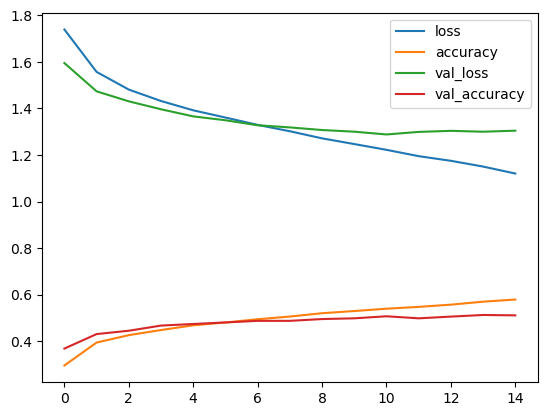

In [46]:
pd.DataFrame(history.history).plot()